

Prediction : 3 days ahead <br>
optimization through CVgridsearch 

Evaluation: We are using Mean Absolute Error (MAE), Mean Square Error (MSE) and Root Mean Square Error (RMSE)<br>



<h1>Project Workflow</h1>

<img src='https://i.ibb.co/fqgB6b7/image.png'> 

<h1>1- Project Objective</h1>

The electric power distribution problem is the distribution of electricity to different areas depends
on its sequential usage. But predicting the following demand of a specific area is difficult, as it varies with weekdays, holidays, seasons, weather, temperatures, etc. This project is to predict the electrical transformers' oil temperature based on long-term real-world data with high precision.

<h3>Dataset Description</h3>



| Field | Date | HUFL | HULL | MUFL | MULL | LUFL | LULL | OT |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Description | The recorded date | High UseFul Load | High UseLess Load | Middle UseFul Load | Middle UseLess Load | Low UseFul Load | Low UseLess Load | Oil Temperature (target) |

<h1>2-Data Preprocessing</h1>

In [ ]:
# import libraries and packages
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, Dropout, GRU, Bidirectional


In [ ]:
# import dataset
# please download the dataset here: https://github.com/zhouhaoyi/ETDataset/tree/main/ETT-small
df = pd.read_csv("https://github.com/zhouhaoyi/ETDataset/raw/main/ETT-small/ETTh1.csv")
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [ ]:
#check for null values 
df.isnull().sum()

date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64

In [ ]:
#drop duplicates 
df.drop_duplicates(inplace=True)

So we will work on exploring the Data first. To understand the useful Features and stuff. 

<h2>Encoding Cyclical Features </h2>



In [ ]:
hours = df.date.dt.hour  # Extracting the hour from each timestamp. 

#print(df.date.dt.hour[0:25])

df['Sin_Hour'] = np.sin(2 * np.pi * df.date.dt.hour / max(df.date.dt.hour))
df['Cos_Hour'] = np.cos(2 * np.pi * df.date.dt.hour / max(df.date.dt.hour))

df_full = df.copy()



In [ ]:
df = df[['date','HUFL',	'HULL',	'MUFL',	'MULL',	'LUFL' ,'LULL','Sin_Hour',	'Cos_Hour' , 'OT']]

In [ ]:
df

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,Sin_Hour,Cos_Hour,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,0.000000,1.000000,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,0.269797,0.962917,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,0.519584,0.854419,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,0.730836,0.682553,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,0.887885,0.460065,21.948000
...,...,...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,-0.816970,-0.576680,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,-0.942261,-0.334880,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,-0.997669,-0.068242,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,-0.979084,0.203456,9.778000


In [ ]:
'''
months = df_full.date.dt.month  # Extracting the hour from each timestamp. 

#print(df.date.dt.hour[0:25])

df['Sin_month'] = np.sin(2 * np.pi * df_full.date.dt.month / max(df_full.date.dt.month))
df['Cos_month'] = np.cos(2 * np.pi * df_full.date.dt.month / max(df_full.date.dt.month))

df_full = df.copy()
'''

"\nmonths = df_full.date.dt.month  # Extracting the hour from each timestamp. \n\n#print(df.date.dt.hour[0:25])\n\ndf['Sin_month'] = np.sin(2 * np.pi * df_full.date.dt.month / max(df_full.date.dt.month))\ndf['Cos_month'] = np.cos(2 * np.pi * df_full.date.dt.month / max(df_full.date.dt.month))\n\ndf_full = df.copy()\n"

In [ ]:
'''df = df[['HUFL',	'HULL',	'MUFL',	'MULL',	'LUFL' ,'LULL','Sin_Hour',	'Cos_Hour' , 'Sin_month', 'Cos_month','OT']]'''

"df = df[['HUFL',\t'HULL',\t'MUFL',\t'MULL',\t'LUFL' ,'LULL','Sin_Hour',\t'Cos_Hour' , 'Sin_month', 'Cos_month','OT']]"

In [ ]:
df

<h1>3-Exploratory data analysis</h1> 

<h3> Statiscal Analysis </h3>

In [ ]:
df.describe()

<h3> Correlation </h3>

In [ ]:
correlations = df.corr()['OT'].sort_values(ascending=False)
print(correlations)

<h3> Data Visualization </h3>

<h4> Distribution of Oil Temperature </h4>

In [ ]:
plt.hist(df['OT'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Oil Temperature')
plt.ylabel('Frequency')
plt.title('Distribution of Oil Temperature')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

<h4> Oil Temperature Over Time </h4>

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
df_full.plot(x='date', y='OT', ax=ax)
plt.title('Oil Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Temperature')
plt.show()

<h4> Average Oil Temperature by Month </h4>

In [ ]:
month_year_oil_temp = df_full[['date','OT']].copy()
month_year_oil_temp['month'] = month_year_oil_temp['date'].apply(lambda x: x.month)
month_year_oil_temp['year'] = month_year_oil_temp['date'].apply(lambda x: x.year)
month_year_oil_temp.head()
fig, ax = plt.subplots(figsize=(8,6))
sns.set_palette('husl')
sns.barplot(data=month_year_oil_temp, x="month", y="OT", hue="year", errorbar=None)
ax.set_xlabel('Month')
ax.set_ylabel('Oil Temperature')
ax.set_title('Average Oil Temperature by Month')
ax.set_xticks(range(12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

<h4> Average Oil Temperature by Hour </h4>

In [ ]:
hour_year_oil_temp = df_full[['date','OT']].copy()
hour_year_oil_temp['hour'] = hour_year_oil_temp['date'].apply(lambda x: x.hour)
hour_year_oil_temp['year'] = hour_year_oil_temp['date'].apply(lambda x: x.year)
hour_year_oil_temp.head()
fig, ax = plt.subplots(figsize=(12,6))
sns.set_palette('husl')
sns.barplot(data=hour_year_oil_temp, x="hour", y="OT",hue="year", errorbar=None)
ax.set_xlabel('Hour')
ax.set_ylabel('Oil Temperature')
ax.set_title('Average Oil Temperature by Hour')
plt.show()

<h1>4-Modeling </h1>

<h2> Data Splitting </h2>

In [ ]:
#define X and y 
df.set_index('date',inplace=True)
X = df[['HUFL',	'HULL',	'MUFL',	'MULL',	'LUFL' ,'LULL','Sin_Hour',	'Cos_Hour']]
y = df['OT']
#split data
X_train , X_test , y_train , y_test =  train_test_split(X , y , train_size = 0.8 , shuffle=False )
X_valid , X_test , y_valid , y_test =  train_test_split(X_test , y_test , train_size = 0.5 , shuffle=False )


In [ ]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)
print("X_valid", X_valid.shape)
print("y_valid", y_valid.shape)

<h2>Linear Regression (OLS)</h2>

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)

ValueError: ignored

In [ ]:
 y_pred = reg.predict(X_test)

NotFittedError: ignored

In [ ]:
predicted_temp = pd.DataFrame(y_pred,index = X_test.index)

AttributeError: ignored

In [ ]:

# get accuracy scores
print("Coef: ", reg.coef_)
print("R2 Score:", r2_score(y_test, predicted_temp))
print("MAE:", mean_absolute_error(y_test, predicted_temp))
print('MSE:', mean_squared_error(y_test, predicted_temp))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predicted_temp)))

AttributeError: ignored

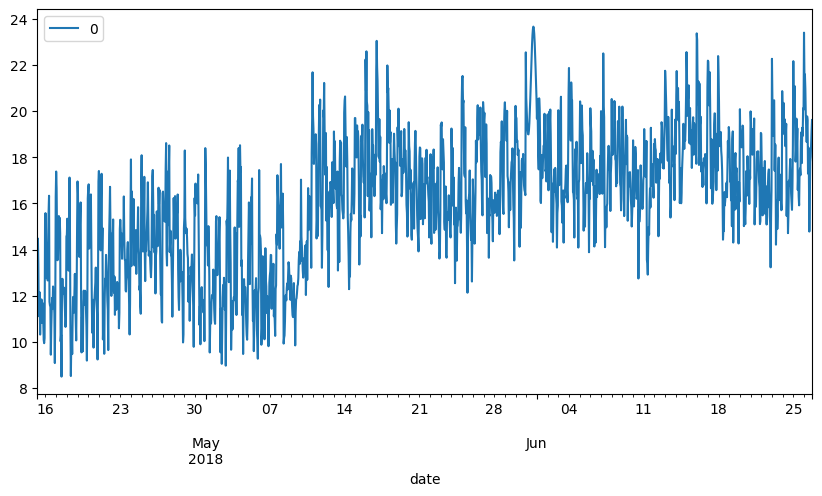

In [ ]:
predicted_temp.plot(figsize=(10,5))
y_test.plot()

plt.title("Linear Regression Performance Using prediction Vs Testing data")
plt.legend(['predicted temperature','actual temperature'])  
plt.ylabel("Predicted temperature VS actual temperature ")  
plt.show()

<h3><h2>Linear Regression ( L2 Regularization)</h2></h3>

In [ ]:
reg2 = Ridge()
reg2.fit(X_train, y_train)

Ridge()

In [ ]:
 y_pred = reg2.predict(X_test)

In [ ]:
predicted_temp = pd.DataFrame(y_pred,index = X_test.index)
# get accuracy scores
print("Coef: ", reg2.coef_)
print("R2 Score:", r2_score(y_test, predicted_temp))
print("MAE:", mean_absolute_error(y_test, predicted_temp))
print('MSE:', mean_squared_error(y_test, predicted_temp))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predicted_temp)))

Coef:  [-0.15828341  1.03957818  0.27763059  0.39350883  1.03613185 -0.18881896
 -2.2209731  -0.73858085]
R2 Score: -8.28499158793584
MAE: 6.412215860695005
MSE: 52.387128375130246
RMSE: 7.237895300094514


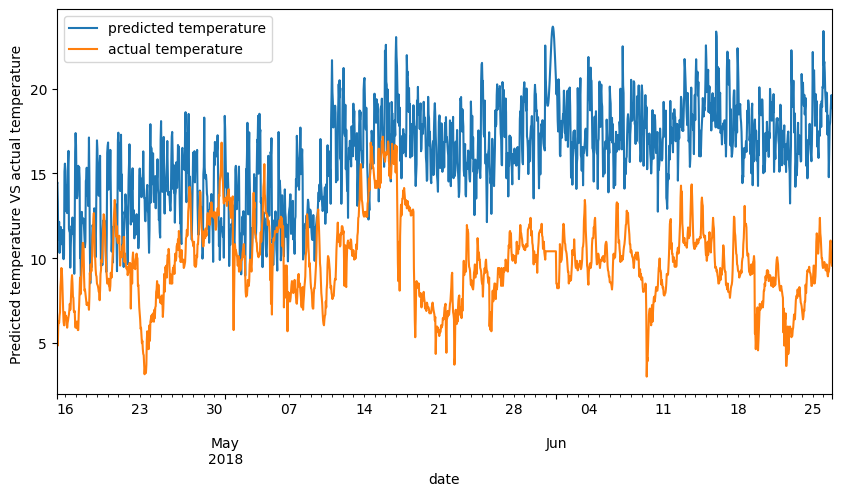

In [ ]:
predicted_temp.plot(figsize=(10,5))
y_test.plot()
plt.legend(['predicted temperature','actual temperature'])  
plt.ylabel("Predicted temperature VS actual temperature ")  
plt.show()

<h3><h2>Support Vector Regression</h2></h3>

In [ ]:
from sklearn.model_selection import GridSearchCV

#param = {'kernel' : ('linear','sigmoid'),'C' : [5,10],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')}
svr = SVR()

#grid_search_svr = GridSearchCV(estimator = svr, param_grid = param,
#                     cv = 4, n_jobs = -1, verbose = 2)
svr.fit(X_train, y_train)

SVR()

MAE: 6.24663459410543
MSE: 53.914069011564536
RMSE: 7.342620037259489


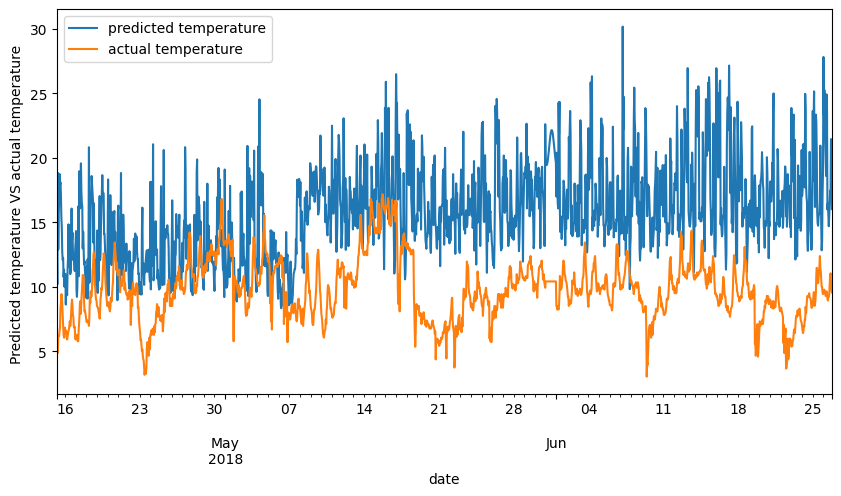

In [ ]:

pred_temp_svr = svr.predict(X_test) 
pred_temp_svr = pd.DataFrame(pred_temp_svr,index=X_test.index)  

# get accuracy scores
print("MAE:", mean_absolute_error(y_test, pred_temp_svr))
print('MSE:', mean_squared_error(y_test, pred_temp_svr))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred_temp_svr)))

# We predict using the test data and plot actual vs predicted temp

pred_temp_svr.plot(figsize=(10,5))  
y_test.plot()
plt.title("SVR Performance Using prediction Vs Testing data")
plt.legend(['predicted temperature','actual temperature'])  
plt.ylabel("Predicted temperature VS actual temperature ")  
plt.show()

<h4> Optimizing Using Grid Search

MAE: 4.233380281483529
MSE: 22.845409390274753
RMSE: 4.779687164477896


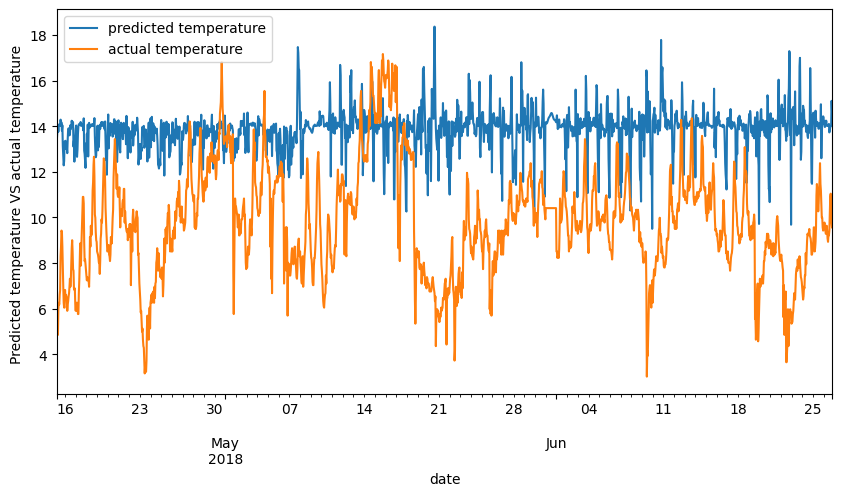

In [ ]:
svr = SVR(C=0.1, degree=2, epsilon=1, gamma=1, kernel='rbf')

#grid_search_svr = GridSearchCV(estimator = svr, param_grid = param,
#                     cv = 4, n_jobs = -1, verbose = 2)
svr.fit(X_train, y_train)


pred_temp_svr = svr.predict(X_test) 
pred_temp_svr = pd.DataFrame(pred_temp_svr,index=X_test.index)  

# get accuracy scores
print("MAE:", mean_absolute_error(y_test, pred_temp_svr))
print('MSE:', mean_squared_error(y_test, pred_temp_svr))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred_temp_svr)))

# We predict using the test data and plot actual vs predicted temp

pred_temp_svr.plot(figsize=(10,5))  
y_test.plot()
plt.legend(['predicted temperature','actual temperature'])  
plt.ylabel("Predicted temperature VS actual temperature ")  
plt.show()

<h2>GRU</h2>

In [ ]:
#define X and y 
#df.set_index('date',inplace=True)
X = df[['HUFL',	'HULL',	'MUFL',	'MULL',	'LUFL' ,'LULL','Sin_Hour',	'Cos_Hour']]
y = df['OT']

In [ ]:
df

,HUFL,HULL,MUFL,MULL,LUFL,LULL,Sin_Hour,Cos_Hour,OT
date,,,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,0.000000,1.000000,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,0.269797,0.962917,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,0.519584,0.854419,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,0.730836,0.682553,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,0.887885,0.460065,21.948000
...,...,...,...,...,...,...,...,...,...
2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,-0.816970,-0.576680,10.904000
2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,-0.942261,-0.334880,11.044000
2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,-0.997669,-0.068242,10.271000


In [ ]:
#Scaler for the target feature only in order to inverse it later after prediction 
from sklearn.preprocessing import MinMaxScaler
y_col = np.array(y)
scaler_y = MinMaxScaler(feature_range=(0,1)).fit(y_col.reshape(-1, 1))
scaled_data_y = scaler_y.transform(y_col.reshape(-1, 1))
#Scaling the modeling data since neural networks need data to be scaled
scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
training_set_scaled = scaler.transform(df)



In [ ]:
df

,HUFL,HULL,MUFL,MULL,LUFL,LULL,Sin_Hour,Cos_Hour,OT
date,,,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,0.000000,1.000000,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,0.269797,0.962917,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,0.519584,0.854419,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,0.730836,0.682553,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,0.887885,0.460065,21.948000
...,...,...,...,...,...,...,...,...,...
2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,-0.816970,-0.576680,10.904000
2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,-0.942261,-0.334880,11.044000
2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,-0.997669,-0.068242,10.271000


In [ ]:
df.iloc[0:5 , 8]

date
2016-07-01 00:00:00    30.531000
2016-07-01 01:00:00    27.787001
2016-07-01 02:00:00    27.787001
2016-07-01 03:00:00    25.044001
2016-07-01 04:00:00    21.948000
Name: OT, dtype: float64

In [ ]:
df_nump = np.array(df)

In [ ]:
def data_split(training_set_scaled):
  '''
  Input: scaled data
  Output: Splited data to training and testing input features and target feature 
    '''
  X = []
  y = []
  past_days = 15

  #Spliting data into X and through a window of 15 preivous days 
  
  for i in range(past_days, training_set_scaled.shape[0]):
      X.append(training_set_scaled[i-past_days:i, 0:8])
      y.append(training_set_scaled[i, 8])
#convert them to numpy array
  X, y = np.array(X), np.array(y)
  X_train , X_test , y_train , y_test =  train_test_split(X , y , train_size = 0.8 , shuffle=False )


  return X_train, X_test, y_train, y_test

In [ ]:
from tensorflow.keras.layers import InputLayer
#GRU
'''
Input: training data for X and y
Output:
model:Compiled and fitted model
history: object to get information about the model training
'''
def GRU_model(X_train, y_train):
    past_days = 15
    tf.random.set_seed(221)
    model = keras.Sequential()

    model.add(GRU(32, dropout=0.25, activation = "tanh" , input_shape= (X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1, activation = 'linear'))
    #compiling the model 
    model.compile(optimizer='adam', loss='mse')
    #fitting the model
    history = model.fit(x=X_train, y=y_train, batch_size=20, validation_split=0.2 , epochs=100, shuffle=True)
    return history , model 

In [ ]:
X_train, X_test, y_train, y_test  = data_split(training_set_scaled)

history_GRU , model_GRU = GRU_model(X_train, y_train ) 

Epoch 1/100
557/557 [==============================] - 5s 5ms/step - loss: 0.0202 - val_loss: 0.0739
Epoch 2/100
557/557 [==============================] - 3s 5ms/step - loss: 0.0177 - val_loss: 0.0686
Epoch 3/100
557/557 [==============================] - 3s 6ms/step - loss: 0.0169 - val_loss: 0.0937
Epoch 4/100
557/557 [==============================] - 3s 5ms/step - loss: 0.0166 - val_loss: 0.0565
Epoch 5/100
557/557 [==============================] - 3s 5ms/step - loss: 0.0163 - val_loss: 0.0556
Epoch 6/100
557/557 [==============================] - 3s 5ms/step - loss: 0.0159 - val_loss: 0.0742
Epoch 7/100
557/557 [==============================] - 4s 7ms/step - loss: 0.0158 - val_loss: 0.0706
Epoch 8/100
557/557 [==============================] - 4s 7ms/step - loss: 0.0151 - val_loss: 0.0562
Epoch 9/100
557/557 [==============================] - 3s 5ms/step - loss: 0.0145 - val_loss: 0.0701
Epoch 10/100
557/557 [==============================] - 3s 5ms/step - loss: 0.0142 - val_lo

In [ ]:
X_train.shape[1]

15

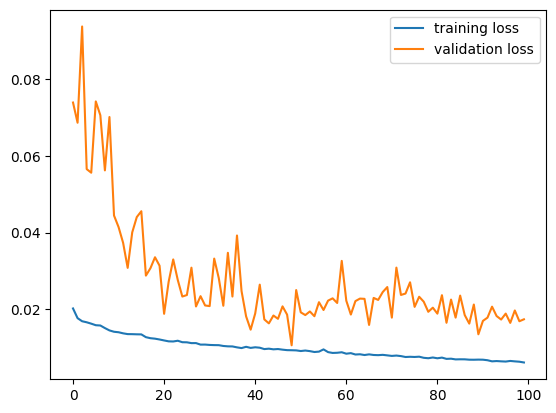

In [ ]:
plt.plot(history_GRU.history['loss'], label = 'training loss')
plt.plot(history_GRU.history['val_loss'], label ='validation loss')
plt.legend()

109/109 [==============================] - 1s 2ms/step


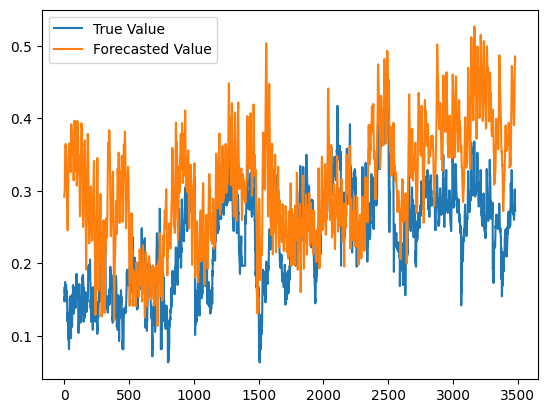

In [ ]:
y_pred = model_GRU.predict(X_test)
plt.plot(y_test, label = 'True Value')
plt.plot(y_pred, label = 'Forecasted Value')
plt.legend()

In [ ]:
y_pred_single_df = pd.DataFrame(scaler_y.inverse_transform(y_pred.reshape(-1, 1)),\
                                index = df[-y_test.shape[0]:].index,\
                                columns = ['predicted'])
y_test_df = pd.DataFrame(scaler_y.inverse_transform(y_test.reshape(-1, 1)),\
                                index = df[-y_test.shape[0]:].index,\
                                columns = ['actual'])['actual']

In [ ]:
y_test_df

date
2018-02-01 19:00:00     3.588
2018-02-01 20:00:00     3.306
2018-02-01 21:00:00     3.658
2018-02-01 22:00:00     4.291
2018-02-01 23:00:00     3.939
                        ...  
2018-06-26 15:00:00    10.904
2018-06-26 16:00:00    11.044
2018-06-26 17:00:00    10.271
2018-06-26 18:00:00     9.778
2018-06-26 19:00:00     9.567
Name: actual, Length: 3481, dtype: float64

In [ ]:
#Calculating the RMSE
print("Root Mean Squared Error for this model is ", np.sqrt(mean_squared_error(y_test_df, y_pred_single_df)))

Root Mean Squared Error for this model is  5.174606321167845


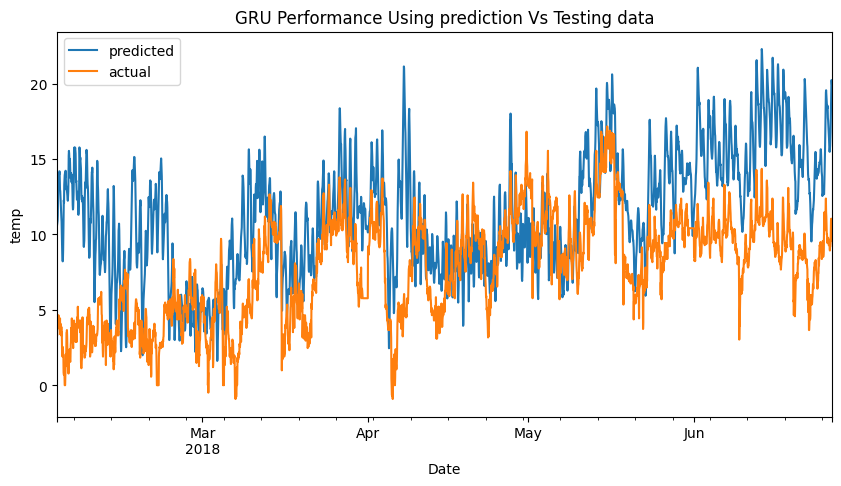

In [ ]:
y_pred_single_df.plot(figsize=(10,5)) 
y_test_df.plot()
plt.title("GRU Performance Using prediction Vs Testing data")
plt.xlabel('Date')
plt.ylabel('temp') 
plt.legend()
plt.show()

<h2>LSTM</h2> 

In [ ]:
#define X and y 
#df.set_index('date',inplace=True)
X = df[['HUFL',	'HULL',	'MUFL',	'MULL',	'LUFL' ,'LULL','Sin_Hour',	'Cos_Hour']]
y = df['OT']

In [ ]:
df

,HUFL,HULL,MUFL,MULL,LUFL,LULL,Sin_Hour,Cos_Hour,OT
date,,,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,0.000000,1.000000,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,0.269797,0.962917,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,0.519584,0.854419,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,0.730836,0.682553,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,0.887885,0.460065,21.948000
...,...,...,...,...,...,...,...,...,...
2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,-0.816970,-0.576680,10.904000
2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,-0.942261,-0.334880,11.044000
2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,-0.997669,-0.068242,10.271000


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

def LSTM_model(X_train,y_train):
  '''
  Input: training data for X and y
  Output:
  model:Compiled and fitted model
  history: object to get information about the training of the model
  '''
# Define the LSTM model
  tf.random.set_seed(221)
  model = Sequential()
  model.add(LSTM(units=32,dropout = 0.25,activation = "tanh" , input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model.add(LSTM(units=16, return_sequences=False))
  model.add(Dense(units=1, activation='linear'))



# Compile the model
  model.compile(loss='mse', optimizer='adam')

# Train the model
  history = model.fit(x = X_train, y = y_train, epochs=100, batch_size=20, validation_split = 0.2,shuffle=True)
  return history, model

  



In [ ]:
#Scaler for the target feature only in order to inverse it later after prediction 
from sklearn.preprocessing import MinMaxScaler
y_col = np.array(y)
scaler_y = MinMaxScaler(feature_range=(0,1)).fit(y_col.reshape(-1, 1))
scaled_data_y = scaler_y.transform(y_col.reshape(-1, 1))
#Scaling the modeling data since neural networks need data to be scaled
scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
training_set_scaled = scaler.transform(df)


In [ ]:
X_train, X_test, y_train, y_test  = data_split(training_set_scaled)

history_LSTM , model_LSTM = LSTM_model(X_train, y_train ) 

Epoch 1/100
557/557 [==============================] - 8s 9ms/step - loss: 0.0180 - val_loss: 0.0929
Epoch 2/100
557/557 [==============================] - 4s 8ms/step - loss: 0.0165 - val_loss: 0.0908
Epoch 3/100
557/557 [==============================] - 4s 7ms/step - loss: 0.0156 - val_loss: 0.1225
Epoch 4/100
557/557 [==============================] - 4s 7ms/step - loss: 0.0153 - val_loss: 0.0858
Epoch 5/100
557/557 [==============================] - 5s 8ms/step - loss: 0.0149 - val_loss: 0.0923
Epoch 6/100
557/557 [==============================] - 4s 7ms/step - loss: 0.0143 - val_loss: 0.0909
Epoch 7/100
557/557 [==============================] - 4s 7ms/step - loss: 0.0143 - val_loss: 0.1047
Epoch 8/100
557/557 [==============================] - 5s 9ms/step - loss: 0.0138 - val_loss: 0.1043
Epoch 9/100
557/557 [==============================] - 4s 8ms/step - loss: 0.0134 - val_loss: 0.0900
Epoch 10/100
557/557 [==============================] - 4s 7ms/step - loss: 0.0133 - val_lo

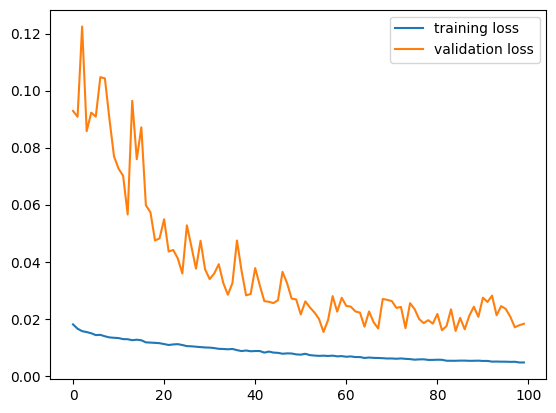

In [ ]:
plt.plot(history_LSTM.history['loss'], label = 'training loss')
plt.plot(history_LSTM.history['val_loss'], label ='validation loss')
plt.legend()

109/109 [==============================] - 2s 4ms/step


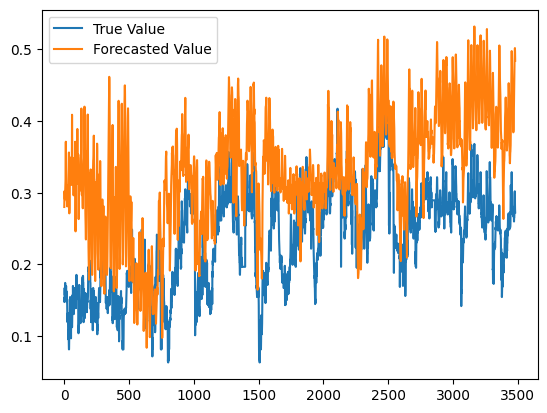

In [ ]:
y_pred = model_LSTM.predict(X_test)
plt.plot(y_test, label = 'True Value')
plt.plot(y_pred, label = 'Forecasted Value')
plt.legend()

In [ ]:
y_pred_single_df = pd.DataFrame(scaler_y.inverse_transform(y_pred.reshape(-1, 1)),\
                                index = df[-y_test.shape[0]:].index,\
                                columns = ['predicted'])
y_test_df = pd.DataFrame(scaler_y.inverse_transform(y_test.reshape(-1, 1)),\
                                index = df[-y_test.shape[0]:].index,\
                                columns = ['actual'])['actual']

In [ ]:
#Calculating the RMSE
print("Root Mean Squared Error for this model is ", np.sqrt(mean_squared_error(y_test_df, y_pred_single_df)))

Root Mean Squared Error for this model is  5.890347621671537


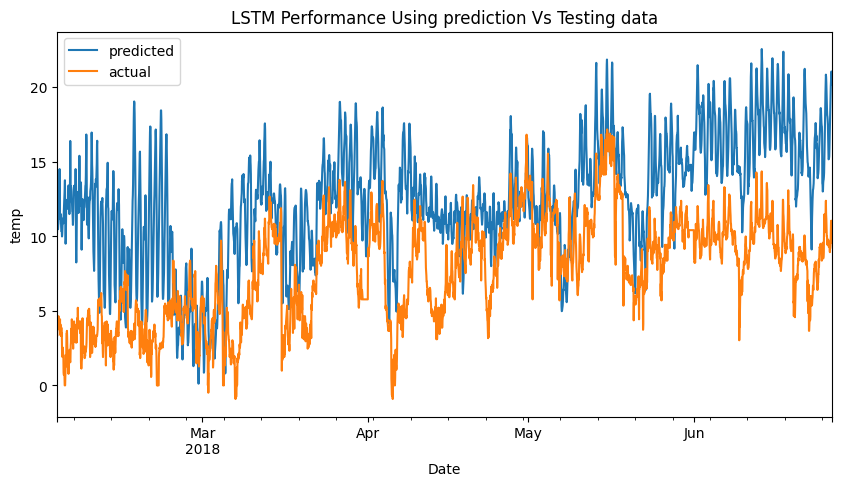

In [ ]:
y_pred_single_df.plot(figsize=(10,5)) 
y_test_df.plot()
plt.title("LSTM Performance Using prediction Vs Testing data")
plt.xlabel('Date')
plt.ylabel('temp') 
plt.legend()
plt.show()

<h2>Dataset Shift</h2>

In order to check if our model generalizes well, we will check the model performance on different test data with different feature ditribution. 

ETTh1 and ETTh2 consist of data from 2 electricity transformers at 2 stations, including load, oil temperature.

ETTh1 is the dataset with which we are training the model.

ETTh2 will serve as dataset shift and we will be able to analyze how well our model can generalize forecasr for a dataset it has never seen befor. 

In [ ]:
df_shift = pd.read_csv("https://github.com/zhouhaoyi/ETDataset/raw/main/ETT-small/ETTh2.csv")
df_shift['date'] = pd.to_datetime(df_shift['date'])

hours = df_shift.date.dt.hour  # Extracting the hour from each timestamp. 

#print(df.date.dt.hour[0:25])

df_shift['Sin_Hour'] = np.sin(2 * np.pi * df_shift.date.dt.hour / max(df_shift.date.dt.hour))
df_shift['Cos_Hour'] = np.cos(2 * np.pi * df_shift.date.dt.hour / max(df_shift.date.dt.hour))

df_shift.set_index('date',inplace=True)
df_shift = df_shift[['HUFL',	'HULL',	'MUFL',	'MULL',	'LUFL' ,'LULL','Sin_Hour',	'Cos_Hour', 'OT']]
X_shift = df_shift[['HUFL',	'HULL',	'MUFL',	'MULL',	'LUFL' ,'LULL','Sin_Hour',	'Cos_Hour']]
y_shift = df_shift['OT']
# X_train , X_shift , y_train , y_shift =  train_test_split(X_shift , y_shift , test_size = 0.2 , shuffle=False )
df_shift
print(X_shift.shape[0])
print(X.shape[0])

17420
17420


In [ ]:
# # First we will calculate the distance between ETTh1, and ETTh2 using Maximum Mean Discrepancy
# from scipy.spatial.distance import cdist
# def mmd(X, Y):
#     """
#     Compute the Maximum Mean Discrepancy (MMD) between two datasets X and Y.
#     """
#     X = np.atleast_2d(X)
#     Y = np.atleast_2d(Y)
#     sigma2 = np.median(cdist(X, X, metric='euclidean')) ** 2
#     KXX = np.exp(-cdist(X, X, metric='sqeuclidean') / sigma2)
#     KYY = np.exp(-cdist(Y, Y, metric='sqeuclidean') / sigma2)
#     KXY = np.exp(-cdist(X, Y, metric='sqeuclidean') / sigma2)
#     return np.mean(KXX) + np.mean(KYY) - 2 * np.mean(KXY)
# print(mmd(X, X_shift))

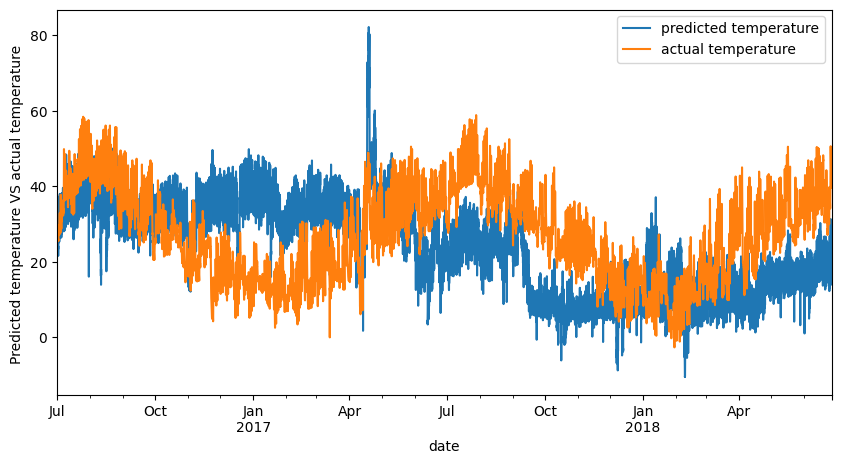

In [ ]:
#Then we will test the model results for ETTh2, comparing to the actual labels.
y_pred_shift = reg.predict(X_shift) 
predicted_temp_shift = pd.DataFrame(y_pred_shift,index = X_shift.index)
predicted_temp_shift.plot(figsize=(10,5))
y_shift.plot()
plt.legend(['predicted temperature','actual temperature'])  
plt.ylabel("Predicted temperature VS actual temperature ")  
plt.show()


MAE: 14.056056251959333
MSE: 299.9071854161634
RMSE: 17.317828542174777


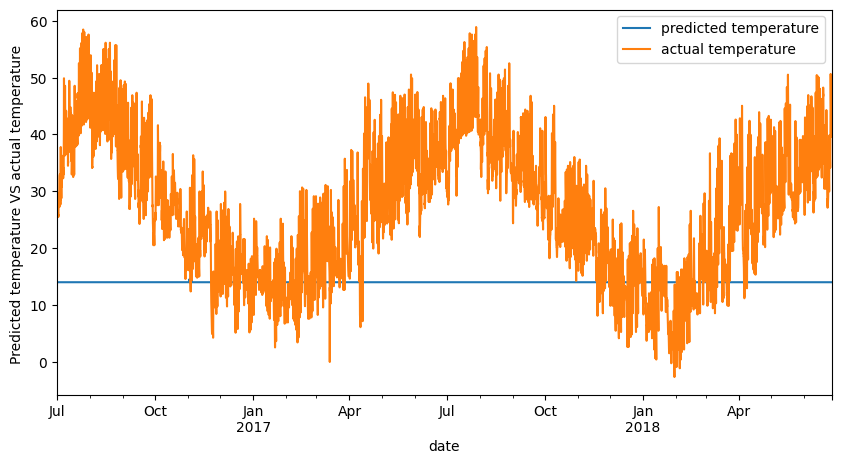

In [ ]:
y_pred_shift = svr.predict(X_shift) 
predicted_temp_shift = pd.DataFrame(y_pred_shift,index = X_shift.index)
print("MAE:", mean_absolute_error(y_shift, predicted_temp_shift))
print('MSE:', mean_squared_error(y_shift, predicted_temp_shift))
print('RMSE:', np.sqrt(mean_squared_error(y_shift, predicted_temp_shift)))
predicted_temp_shift.plot(figsize=(10,5))
y_shift.plot()
plt.legend(['predicted temperature','actual temperature'])  
plt.ylabel("Predicted temperature VS actual temperature ")  
plt.show()

Additonally we can combine both datasets and isolate a specific year or month to create a dataset shift and check how our model deals with such abnormality. 

<h2> Data shift with GRU 

In [ ]:
#Scaler for the target feature only in order to inverse it later after prediction 
from sklearn.preprocessing import MinMaxScaler
y_col = np.array(y_shift)
scaler_y = MinMaxScaler(feature_range=(0,1)).fit(y_col.reshape(-1, 1))
scaled_data_y = scaler_y.transform(y_col.reshape(-1, 1))
#Scaling the modeling data since neural networks need data to be scaled
scaler = MinMaxScaler(feature_range=(0,1)).fit(df_shift)
training_set_scaled = scaler.transform(df_shift)

In [ ]:
X_train, X_test, y_train, y_test  =  data_split(training_set_scaled)

In [ ]:
X_test.shape

(3481, 15, 8)

109/109 [==============================] - 0s 2ms/step


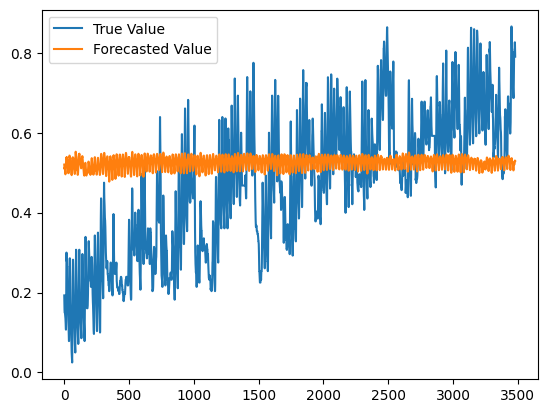

In [ ]:
y_pred_shift = model_GRU.predict(X_test)
plt.plot(y_test, label = 'True Value')
plt.plot(y_pred_shift, label = 'Forecasted Value')
plt.legend()

In [ ]:
y_pred_single_df = pd.DataFrame(scaler_y.inverse_transform(y_pred_shift.reshape(-1, 1)),\
                                index = df[-y_test.shape[0]:].index,\
                                columns = ['predicted'])
y_test_df = pd.DataFrame(scaler_y.inverse_transform(y_test.reshape(-1, 1)),\
                                index = df[-y_test.shape[0]:].index,\
                                columns = ['actual'])['actual']

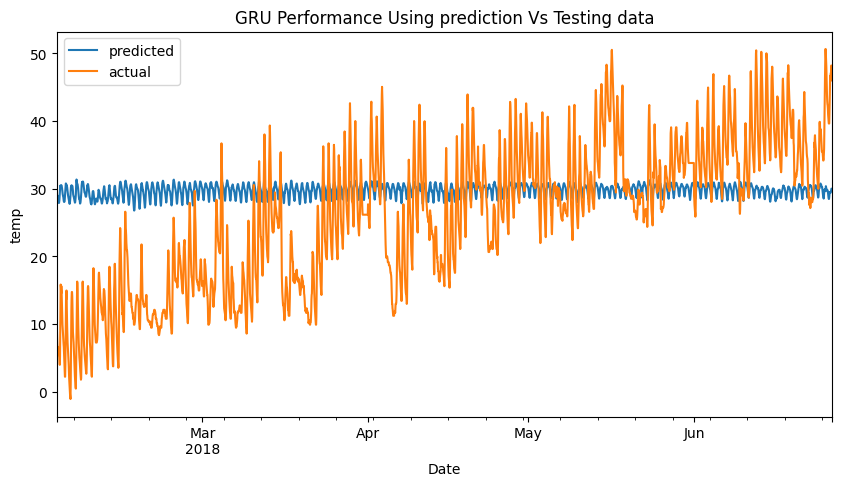

In [ ]:
y_pred_single_df.plot(figsize=(10,5)) 
y_test_df.plot()
plt.title("GRU Performance Using prediction Vs Testing data")
plt.xlabel('Date')
plt.ylabel('temp') 
plt.legend()
plt.show()

In [ ]:
print("Root Mean Squared Error for this model is ", np.sqrt(mean_squared_error(y_test_df, y_pred_single_df)))

Root Mean Squared Error for this model is  10.984201076766253


<h2> Data shift with LSTM

In [ ]:
X_train, X_test, y_train, y_test  =  data_split(training_set_scaled)

In [ ]:
X_test.shape

(3481, 15, 8)

109/109 [==============================] - 0s 3ms/step


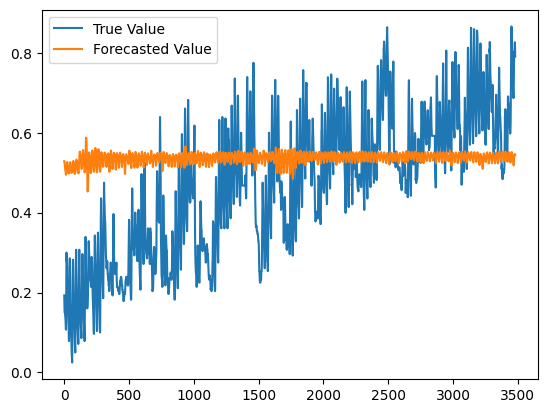

In [ ]:
y_pred_shift = model_LSTM.predict(X_test)
plt.plot(y_test, label = 'True Value')
plt.plot(y_pred_shift, label = 'Forecasted Value')
plt.legend()

In [ ]:
y_pred_single_df = pd.DataFrame(scaler_y.inverse_transform(y_pred_shift.reshape(-1, 1)),\
                                index = df[-y_test.shape[0]:].index,\
                                columns = ['predicted'])
y_test_df = pd.DataFrame(scaler_y.inverse_transform(y_test.reshape(-1, 1)),\
                                index = df[-y_test.shape[0]:].index,\
                                columns = ['actual'])['actual']

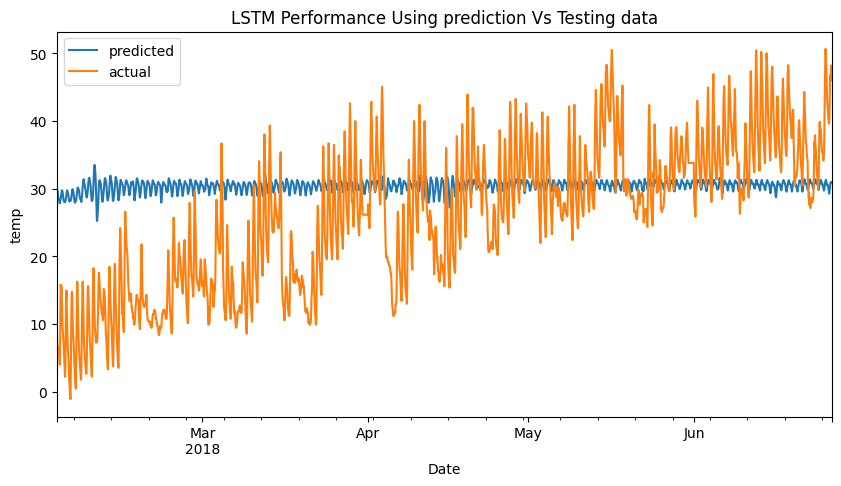

In [ ]:
y_pred_single_df.plot(figsize=(10,5)) 
y_test_df.plot()
plt.title("LSTM Performance Using prediction Vs Testing data")
plt.xlabel('Date')
plt.ylabel('temp') 
plt.legend()
plt.show()

In [ ]:
print("Root Mean Squared Error for this model is ", np.sqrt(mean_squared_error(y_test_df, y_pred_single_df)))

Root Mean Squared Error for this model is  11.244471027213669
